In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
# Load dataset
data = pd.read_csv('D:\\Excel data\\Saliva\\Healthy (Control)\\CONTROL DATASET.csv')

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [3]:
# PCA
pca = PCA(n_components=0.999)  
data_pca = pca.fit_transform(data_scaled)

In [4]:
# Convert the normalized data to a PyTorch tensor
data_tensor = torch.tensor(data_pca, dtype=torch.float32)

# Data dimensions (number of features)
input_dim = data_tensor.shape[1]

In [5]:
data.describe()

,Wavelenght399,Wavelenght400,Wavelenght401,Wavelenght402,Wavelenght403,Wavelenght404,Wavelenght405,Wavelenght406,Wavelenght407,Wavelenght408,...,Wavelenght4125,Wavelenght4126,Wavelenght4127,Wavelenght4128,Wavelenght4129,Wavelenght4130,Wavelenght4131,Wavelenght4132,Wavelenght4133,Wavelenght4134
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.012250,0.012573,0.012779,0.012926,0.013061,0.013238,0.013531,0.014002,0.014646,0.015350,...,0.040388,0.040300,0.040234,0.040180,0.040106,0.039998,0.039881,0.039802,0.039797,0.040209
std,0.015259,0.012853,0.011097,0.010596,0.010968,0.011433,0.011563,0.011362,0.011077,0.010877,...,0.018788,0.018811,0.018828,0.018838,0.018845,0.018849,0.018849,0.018842,0.018833,0.018927
min,-0.014772,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,...,0.006680,0.006636,0.006627,0.006655,0.006709,0.006764,0.006788,0.006755,0.006663,0.006622
25%,0.001975,0.001600,0.003526,0.004287,0.004016,0.003564,0.003591,0.004327,0.005191,0.006842,...,0.025167,0.025067,0.025030,0.025106,0.025090,0.024775,0.024625,0.024532,0.024590,0.024983
50%,0.007490,0.007041,0.009273,0.009949,0.009853,0.009641,0.010528,0.011109,0.011913,0.012970,...,0.038208,0.038166,0.037753,0.037555,0.037466,0.037299,0.037059,0.037192,0.037245,0.037873
75%,0.021905,0.021530,0.019229,0.020147,0.020276,0.020476,0.019827,0.020090,0.021587,0.022612,...,0.054194,0.054263,0.054213,0.054108,0.054246,0.054207,0.054018,0.054151,0.054101,0.054605
max,0.061457,0.057453,0.053860,0.048561,0.044788,0.047300,0.049513,0.049830,0.047316,0.047338,...,0.094441,0.094415,0.094062,0.093442,0.092693,0.092002,0.091551,0.091427,0.091561,0.092710


In [7]:
# Wrap the tensor in a TensorDataset (no labels in your case, just features)
dataset = TensorDataset(data_tensor)

# Create a DataLoader
batch_size = 64
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Example: iterate over batches
for batch in data_loader:
    inputs = batch[0]  
    print(inputs.shape)

torch.Size([64, 62])
torch.Size([64, 62])
torch.Size([64, 62])
torch.Size([64, 62])
torch.Size([64, 62])
torch.Size([64, 62])
torch.Size([64, 62])
torch.Size([52, 62])


In [8]:
# Wrap data tensor in a TensorDataset
dataset = TensorDataset(data_tensor)

# Define split ratio 
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for each split
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Example: Access batches
for batch in train_loader:
    inputs = batch[0]
    print(f"Train batch shape: {inputs.shape}")
    break

for batch in test_loader:
    inputs = batch[0]
    print(f"Test batch shape: {inputs.shape}")
    break

Train batch shape: torch.Size([64, 62])
Test batch shape: torch.Size([64, 62])


In [9]:
# Xavier initialization
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)


In [10]:
noise_dim = 100
input_dim = 3736
epochs = 10000
batch_size = 64


# Generator network (improved)
class Generator(nn.Module):
    def __init__(self, noise_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, output_dim),
        )

    def forward(self, x):
        return self.model(x)

# Discriminator network (improved)
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [11]:
input_dim = data_tensor.shape[1]
noise_dim = 100  

generator = Generator(noise_dim=noise_dim, output_dim=input_dim)
discriminator = Discriminator(input_dim=input_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=62, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [12]:
# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(noise_dim=noise_dim, output_dim=input_dim).to(device)
discriminator = Discriminator(input_dim=input_dim).to(device)

In [13]:
# Hyperparameters
noise_dim = 100
input_dim = 3736
epochs = 10000
batch_size = 64
lr_D = 0.0001
lr_G = 0.0002
beta1 = 0.5

adversarial_loss = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

scheduler_G = torch.optim.lr_scheduler.StepLR(optimizer_G, step_size=300, gamma=0.95)
scheduler_D = torch.optim.lr_scheduler.StepLR(optimizer_D, step_size=300, gamma=0.95)

In [14]:
# Apply weight initialization
generator.apply(weights_init)
discriminator.apply(weights_init)

print("Models initialized & moved to:", device)

Models initialized & moved to: cpu


In [15]:
# Function to generate random noise for the generator
def generate_latent_points(batch_size, noise_dim, device):
    return torch.randn(batch_size, noise_dim, device=device)

Epoch [1000/10000] | D Loss: 0.7009 | G Loss: 0.7597
Generated images shape: (16, 62)
Epoch [2000/10000] | D Loss: 0.6884 | G Loss: 0.7172
Generated images shape: (16, 62)
Epoch [3000/10000] | D Loss: 0.6693 | G Loss: 0.7169
Generated images shape: (16, 62)
Epoch [4000/10000] | D Loss: 0.6458 | G Loss: 0.7430
Generated images shape: (16, 62)
Epoch [5000/10000] | D Loss: 0.6659 | G Loss: 0.7583
Generated images shape: (16, 62)
Epoch [6000/10000] | D Loss: 0.6753 | G Loss: 0.8338
Generated images shape: (16, 62)
Epoch [7000/10000] | D Loss: 0.6664 | G Loss: 0.8178
Generated images shape: (16, 62)
Epoch [8000/10000] | D Loss: 0.6781 | G Loss: 0.8020
Generated images shape: (16, 62)
Epoch [9000/10000] | D Loss: 0.6151 | G Loss: 0.8202
Generated images shape: (16, 62)
Epoch [10000/10000] | D Loss: 0.6494 | G Loss: 0.9072
Generated images shape: (16, 62)


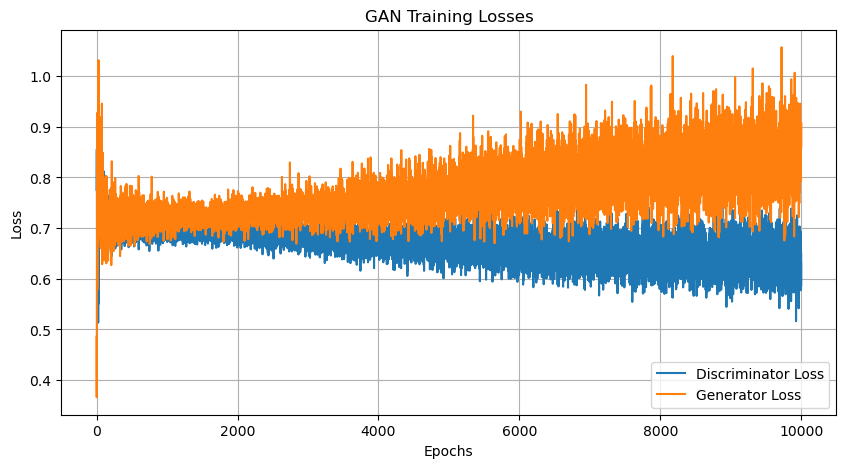

In [16]:
# Loss tracking
d_losses = []
g_losses = []

for epoch in range(epochs):
    generator.train()
    discriminator.train()

    for batch in train_loader:
        real_data = batch[0].to(device)
        batch_size_real = real_data.size(0)

        # Add Gaussian noise to real data
        noisy_real_data = real_data + 0.1 * torch.randn_like(real_data)

        # Labels with smoothing and noise
        real_labels = 0.9 + 0.1 * torch.rand((batch_size_real, 1), device=device)
        fake_labels = 0.05 * torch.rand((batch_size_real, 1), device=device)

        # --- Train Discriminator ---
        optimizer_D.zero_grad()

        z = generate_latent_points(batch_size_real, noise_dim, device)
        fake_data = generator(z)

        d_real = discriminator(noisy_real_data)
        d_fake = discriminator(fake_data.detach())

        d_loss_real = adversarial_loss(d_real, real_labels)
        d_loss_fake = adversarial_loss(d_fake, fake_labels)
        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()

        # --- Train Generator ---
        for _ in range(3):
            optimizer_G.zero_grad()
            z = generate_latent_points(batch_size_real, noise_dim, device)
            fake_data = generator(z)
            d_fake = discriminator(fake_data)
            g_loss = adversarial_loss(d_fake, real_labels)
            g_loss.backward()
            optimizer_G.step()

    scheduler_G.step()
    scheduler_D.step()

    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")
        with torch.no_grad():
            test_fake = generator(generate_latent_points(16, noise_dim, device)).cpu().numpy()
            print("Generated images shape:", test_fake.shape)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title("GAN Training Losses")
plt.show()

In [17]:
def generate_synthetic_data(generator, noise_dim, num_samples, device, pca=None, scaler=None):
   
    # Set generator to evaluation mode
    generator.eval()

    # Generate random noise (latent points)
    z = generate_latent_points(num_samples, noise_dim, device)

    # Generate synthetic data in PCA space
    with torch.no_grad():
        synthetic_pca_data = generator(z).cpu().numpy()

    # Inverse PCA transform 
    if pca:
        synthetic_scaled = pca.inverse_transform(synthetic_pca_data)
    else:
        synthetic_scaled = synthetic_pca_data  

    # Inverse scaling 
    if scaler:
        synthetic_final = scaler.inverse_transform(synthetic_scaled)
    else:
        synthetic_final = synthetic_scaled

    return synthetic_final


# === Example Usage ===

# Number of synthetic samples to generate
num_samples = 500

# Generate synthetic data
synthetic_data = generate_synthetic_data(
    generator=generator,
    noise_dim=noise_dim,
    num_samples=num_samples,
    device=device,
    pca=pca,       
    scaler=scaler  
)

# Convert to DataFrame
synthetic_df = pd.DataFrame(synthetic_data, columns=data.columns if 'data' in globals() else None)

# Display result
print(synthetic_df.head())

   Wavelenght399  Wavelenght400  Wavelenght401  Wavelenght402  Wavelenght403  \
0       0.018797       0.009810       0.004436       0.001807       0.000884   
1       0.003198       0.009149       0.014364       0.018525       0.021777   
2       0.011356       0.006359       0.004102       0.003957       0.005021   
3      -0.005648       0.002894       0.009601       0.013492       0.014800   
4       0.014487       0.011913       0.009181       0.008014       0.008739   

   Wavelenght404  Wavelenght405  Wavelenght406  Wavelenght407  Wavelenght408  \
0       0.001515       0.004296       0.009688       0.017122       0.024941   
1       0.024080       0.025248       0.025260       0.024365       0.022821   
2       0.006604       0.008327       0.010102       0.011993       0.013973   
3       0.014495       0.013707       0.013283       0.013448       0.013679   
4       0.010623       0.012392       0.012854       0.011555       0.009052   

   ...  Wavelenght4125  Wavelenght4126

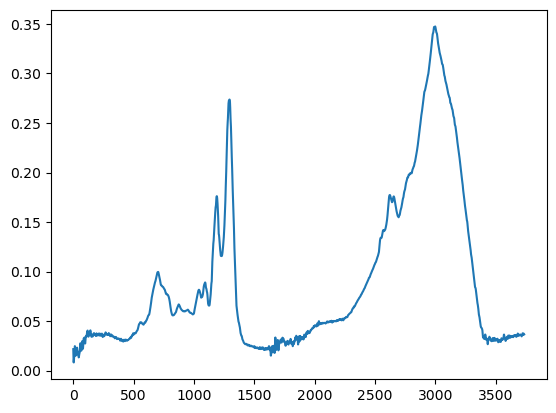

In [18]:
plt.plot(synthetic_data [10,:])

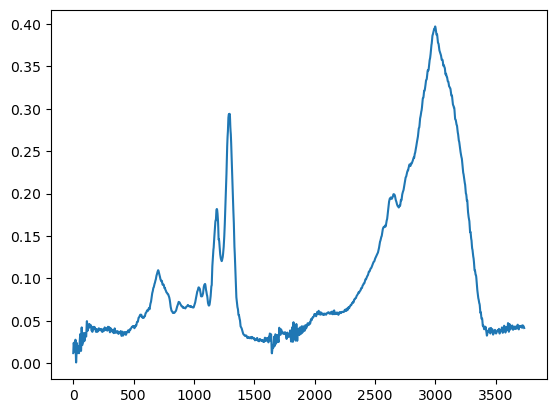

In [19]:
data = np.array(data) 
plt.plot(data[10, :]) 

In [20]:
# Save to CSV
synthetic_df.to_csv('synthetic_dataN.csv', index=False)

In [21]:
synthetic_data = pd.read_csv('C:\\Users\\Ahmed\\Final\\synthetic_dataN.csv') 

In [22]:
synthetic_data.describe()

,Wavelenght399,Wavelenght400,Wavelenght401,Wavelenght402,Wavelenght403,Wavelenght404,Wavelenght405,Wavelenght406,Wavelenght407,Wavelenght408,...,Wavelenght4125,Wavelenght4126,Wavelenght4127,Wavelenght4128,Wavelenght4129,Wavelenght4130,Wavelenght4131,Wavelenght4132,Wavelenght4133,Wavelenght4134
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.012033,0.012546,0.012792,0.013054,0.013441,0.013904,0.014320,0.014600,0.014757,0.014871,...,0.038939,0.038843,0.038776,0.038710,0.038611,0.038478,0.038353,0.038287,0.038308,0.038706
std,0.015418,0.012362,0.010221,0.009860,0.010551,0.011216,0.011456,0.011359,0.011126,0.010814,...,0.017443,0.017462,0.017410,0.017318,0.017220,0.017142,0.017097,0.017089,0.017124,0.017247
min,-0.068944,-0.034900,-0.022726,-0.016260,-0.009487,-0.017945,-0.022098,-0.017515,-0.006857,-0.010018,...,0.006114,0.006289,0.006588,0.006827,0.006883,0.006774,0.006633,0.006580,0.006172,0.006860
25%,0.003379,0.005195,0.005909,0.006360,0.006325,0.006746,0.007031,0.007721,0.008175,0.008194,...,0.025614,0.025533,0.025400,0.025222,0.025054,0.024910,0.025017,0.024984,0.025075,0.025615
50%,0.011340,0.011140,0.011368,0.011542,0.011977,0.011714,0.012098,0.012561,0.013094,0.013568,...,0.035719,0.035406,0.035186,0.035099,0.035065,0.034750,0.034865,0.034853,0.034932,0.035338
75%,0.020644,0.018004,0.017508,0.018866,0.018524,0.018868,0.019568,0.019340,0.019050,0.019166,...,0.049686,0.050063,0.049787,0.049557,0.049259,0.049136,0.048975,0.048945,0.049144,0.049526
max,0.072379,0.068476,0.063415,0.058169,0.063272,0.080937,0.092214,0.098958,0.102022,0.100306,...,0.089351,0.089284,0.088809,0.088325,0.087806,0.087533,0.087428,0.087088,0.087459,0.088393
